# 🎬 Avenue Anomaly Detection - Vectorized High Accuracy Version

## I3D + Simple Autoencoder + Feature Normalization + Full Vectorization

This notebook implements a **video anomaly detection** pipeline using:

1. **I3D (Inflated 3D ConvNet)** - Pre-trained video feature extractor from Facebook's PyTorchVideo
2. **Simple Autoencoder** - Learns to reconstruct normal video features
3. **Anomaly Scoring** - Uses reconstruction error to identify anomalies
4. **Visualizations** - Includes pixel-level heatmaps (Grad-CAM) and t-SNE embeddings

### Key Features:
- ✅ Vectorized operations for speed
- ✅ Feature caching for faster re-runs
- ✅ Proper train/test normalization
- ✅ Pixel-level anomaly heatmaps (Grad-CAM)
- ✅ t-SNE visualization of feature space
- ✅ AUC computation with ground truth

---


## 1. 📦 Import Libraries

Import all necessary libraries for data processing, deep learning, and visualization.


In [1]:
# Standard libraries
import os
import random
import time
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm.auto import tqdm
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor
from typing import List, Dict, Tuple

# PyTorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


PyTorch version: 2.8.0+cu126
CUDA available: True


## 2. ⚙️ Configuration

Set up all hyperparameters, paths, and visualization toggles.

### Configuration Parameters:
- **IMG_SIZE**: Input image size (224x224 for I3D)
- **SEQ_LEN**: Number of frames per video clip (16 for I3D)
- **BATCH_SIZE**: Batch size for I3D feature extraction
- **TRAIN_BATCH**: Batch size for autoencoder training
- **NUM_EPOCHS**: Number of training epochs
- **ENABLE_HEATMAPS**: Toggle for pixel-level heatmap visualization
- **ENABLE_TSNE**: Toggle for t-SNE visualization


In [2]:
# =============================================================================
# MODEL & TRAINING HYPERPARAMETERS
# =============================================================================

IMG_SIZE = 224              # Input image size (I3D requirement)
SEQ_LEN = 16                # Number of frames per clip (I3D requirement)
BATCH_SIZE = 4              # Batch size for I3D feature extraction
TRAIN_BATCH = 128           # Batch size for autoencoder training
NUM_EPOCHS = 100            # Number of training epochs
LEARNING_RATE = 5e-4        # Learning rate for AdamW optimizer
WEIGHT_DECAY = 1e-5         # Weight decay for regularization
NUM_WORKERS = 4             # Number of parallel workers for data loading

# =============================================================================
# CACHE DIRECTORIES
# =============================================================================

CACHE_DIR = "/kaggle/working/cache"
FEATURE_CACHE = os.path.join(CACHE_DIR, "features")

# =============================================================================
# VISUALIZATION TOGGLES
# =============================================================================

# Heatmap Visualization (Grad-CAM)
ENABLE_HEATMAPS = True        # Set to False to disable heatmap generation
HEATMAP_FRAMES = 8            # Number of frames to visualize
HEATMAP_VIDEO_IDX = 1         # Which test video to visualize (1-indexed)

# t-SNE Visualization
ENABLE_TSNE = True            # Set to False to disable t-SNE visualization
TSNE_PERPLEXITY = 30          # t-SNE perplexity parameter (typical: 5-50)
TSNE_MAX_SAMPLES = 2000       # Max samples for t-SNE (for speed)

# =============================================================================
# DATASET PATHS
# =============================================================================

DATA_ROOT = "/kaggle/input/avenue-dataset/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset"
TRAIN_DIR = os.path.join(DATA_ROOT, "training_videos")
TEST_DIR = os.path.join(DATA_ROOT, "testing_videos")
OUTPUT_CSV = "avenue_scores.csv"

print("Configuration loaded!")
print(f"  - Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  - Sequence length: {SEQ_LEN} frames")
print(f"  - Training epochs: {NUM_EPOCHS}")
print(f"  - Heatmaps enabled: {ENABLE_HEATMAPS}")
print(f"  - t-SNE enabled: {ENABLE_TSNE}")


Configuration loaded!
  - Image size: 224x224
  - Sequence length: 16 frames
  - Training epochs: 100
  - Heatmaps enabled: True
  - t-SNE enabled: True


In [3]:
# =============================================================================
# REPRODUCIBILITY & DEVICE SETUP
# =============================================================================

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Enable cuDNN benchmark for faster training on fixed input sizes
torch.backends.cudnn.benchmark = True

# Select device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create cache directory for storing features
os.makedirs(FEATURE_CACHE, exist_ok=True)
print(f"Feature cache directory: {FEATURE_CACHE}")


Using device: cuda
Feature cache directory: /kaggle/working/cache/features


## 3. 🖼️ Vectorized Image Loading

Efficient image loading utilities using:
- **ThreadPoolExecutor** for parallel I/O operations
- **Vectorized normalization** using numpy broadcasting
- **ImageNet-style normalization** (mean=0.45, std=0.225)


In [4]:
# =============================================================================
# NORMALIZATION CONSTANTS
# =============================================================================

# Pre-shaped for broadcasting: (1, 1, 1, 3) to match (N, H, W, C)
MEAN = np.array([0.45, 0.45, 0.45], dtype=np.float32).reshape(1, 1, 1, 3)
STD = np.array([0.225, 0.225, 0.225], dtype=np.float32).reshape(1, 1, 1, 3)


def load_single_image_raw(path: str) -> np.ndarray:
    """
    Load a single image as uint8 (no normalization yet).
    
    Args:
        path: Path to the image file
        
    Returns:
        img: (H, W, C) uint8 numpy array
    """
    img = cv2.imread(path)
    if img is None:
        # Return black image if loading fails
        return np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
    # Convert BGR to RGB and resize
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)
    return img


def load_images_vectorized(paths: List[str]) -> np.ndarray:
    """
    VECTORIZED: Load multiple images in parallel with efficient normalization.
    
    Uses ThreadPoolExecutor for parallel I/O and vectorized numpy operations
    for normalization.
    
    Args:
        paths: List of image file paths
        
    Returns:
        batch: (N, H, W, C) float32 normalized numpy array
    """
    # Parallel I/O loading using thread pool
    with ThreadPoolExecutor(max_workers=NUM_WORKERS) as executor:
        images = list(executor.map(load_single_image_raw, paths))
    
    # VECTORIZED: Stack and normalize in one operation
    batch = np.stack(images, axis=0).astype(np.float32)  # (N, H, W, C)
    batch = (batch / 255.0 - MEAN) / STD  # Vectorized normalization
    
    return batch


def load_clip_vectorized(frame_paths: List[str]) -> np.ndarray:
    """
    Load a video clip with vectorized normalization.
    
    Args:
        frame_paths: List of frame image paths
        
    Returns:
        clip: (T, H, W, C) float32 normalized numpy array
    """
    return load_images_vectorized(frame_paths)


def get_frame_num(path: str) -> int:
    """
    Extract frame number from filename.
    
    Args:
        path: Path to frame image
        
    Returns:
        frame_num: Integer frame number extracted from filename
    """
    name = os.path.basename(path)
    digits = ''.join(filter(str.isdigit, os.path.splitext(name)[0]))
    return int(digits) if digits else 0


print("Image loading functions defined!")


Image loading functions defined!


## 4. I3D Feature Extractor

I3D (Inflated 3D ConvNet) is a powerful video understanding model that:
- Uses 3D convolutions to capture spatiotemporal patterns
- Pre-trained on Kinetics dataset for action recognition
- Outputs 2048-dimensional feature vectors per video clip

We use a Singleton pattern to ensure the model is loaded only once.


In [5]:
class I3D(nn.Module):
    """
    Singleton I3D model wrapper.
    
    Uses Facebook's PyTorchVideo i3d_r50 (ResNet-50 backbone).
    The model is loaded only once and reused across all feature extractions.
    
    Architecture:
        - Input: (B, C, T, H, W) = (batch, 3, 16, 224, 224)
        - Output: (B, 2048) feature vectors
    """
    _instance = None
    
    def __new__(cls):
        # Singleton pattern: return existing instance if available
        if cls._instance is None:
            cls._instance = super().__new__(cls)
            cls._instance._initialized = False
        return cls._instance
    
    def __init__(self):
        if self._initialized:
            return
        super().__init__()
        
        print("Loading I3D model from PyTorchVideo...")
        
        # Load pretrained I3D ResNet-50
        self.model = torch.hub.load(
            'facebookresearch/pytorchvideo', 
            'i3d_r50', 
            pretrained=True
        )
        
        # Remove the classification head, keep features only
        # Replace projection with identity to get raw 2048-dim features
        self.model.blocks[-1].proj = nn.Identity()
        
        # Freeze all parameters (we only use it for feature extraction)
        for p in self.parameters():
            p.requires_grad = False
        
        self.eval()
        self._initialized = True
        print("I3D model loaded successfully!")
    
    @torch.no_grad()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Extract features from video clips.
        
        Args:
            x: Input tensor of shape (B, C, T, H, W)
            
        Returns:
            features: Output tensor of shape (B, 2048)
        """
        return self.model(x)


## 5. Feature Extraction Functions

These functions handle the extraction of I3D features from video frames:

1. extract_features_vectorized: Extract and normalize features from training videos
2. extract_test_features_vectorized: Extract test features using training statistics

Features are cached to disk for faster subsequent runs.


In [6]:
def extract_features_vectorized(data_dir: str, name: str, stride: int = 1) -> Tuple:
    """
    VECTORIZED feature extraction with caching and proper normalization.
    
    This function:
    1. Creates video clips with specified stride
    2. Extracts I3D features for each clip
    3. Computes normalization statistics (mean, std)
    4. Normalizes all features
    5. Caches results to disk
    
    Args:
        data_dir: Directory containing video folders
        name: Name for caching (e.g., "train")
        stride: Stride between consecutive clips
        
    Returns:
        features: (N, 2048) normalized tensor
        clips: List of clip metadata
        videos: Dict of video metadata
        stats: Normalization statistics (mean, std)
    """
    cache_file = os.path.join(FEATURE_CACHE, f"{name}_v2_s{stride}.pt")
    
    # Check cache first
    if os.path.exists(cache_file):
        print(f"[CACHE HIT] Loading {name}")
        data = torch.load(cache_file, weights_only=False)
        return data['features'], data['clips'], data['videos'], data['stats']
    
    print(f"\n{'='*50}")
    print(f"Extracting features: {name} (stride={stride})")
    print(f"{'='*50}")
    
    # Load I3D model
    i3d = I3D().to(device)
    
    # Collect video info
    videos = {}
    clips = []
    
    video_dirs = sorted([d for d in os.listdir(data_dir) 
                        if os.path.isdir(os.path.join(data_dir, d))])
    
    print(f"Found {len(video_dirs)} videos")
    
    # Process each video
    for vid_id, vid_name in enumerate(video_dirs, 1):
        vid_path = os.path.join(data_dir, vid_name)
        frames = sorted(glob.glob(os.path.join(vid_path, "*.jpg")))
        
        if len(frames) < SEQ_LEN:
            continue
        
        # VECTORIZED: Extract all frame numbers at once
        frame_nums = np.array([get_frame_num(f) for f in frames])
        
        videos[vid_id] = {
            'name': vid_name,
            'frames': frames,
            'nums': frame_nums,
            'n': len(frames)
        }
        
        # Create clips with specified stride
        n_clips_vid = (len(frames) - SEQ_LEN) // stride + 1
        for i in range(n_clips_vid):
            start = i * stride
            clips.append({
                'vid': vid_id,
                'start': start,
                'paths': frames[start:start + SEQ_LEN],
                'nums': frame_nums[start:start + SEQ_LEN]
            })
    
    n_clips = len(clips)
    print(f"Total clips: {n_clips}")
    
    # VECTORIZED: Pre-allocate feature tensor
    features = torch.zeros(n_clips, 2048, dtype=torch.float32)
    
    # Extract features in batches
    for i in tqdm(range(0, n_clips, BATCH_SIZE), desc="Extracting I3D"):
        batch_clips = clips[i:i + BATCH_SIZE]
        batch_size = len(batch_clips)
        
        # VECTORIZED: Load all clips for this batch
        batch_data = []
        for clip in batch_clips:
            clip_frames = load_clip_vectorized(clip['paths'])
            batch_data.append(clip_frames)
        
        # Stack: (B, T, H, W, C)
        batch_array = np.stack(batch_data, axis=0)
        
        # VECTORIZED: Convert to PyTorch and permute
        # (B, T, H, W, C) -> (B, C, T, H, W)
        batch_tensor = torch.from_numpy(batch_array).permute(0, 4, 1, 2, 3)
        batch_tensor = batch_tensor.to(device)
        
        # Extract with mixed precision for speed
        with torch.amp.autocast('cuda'):
            feats = i3d(batch_tensor)
        
        # Store in pre-allocated tensor
        features[i:i + batch_size] = feats.cpu()
    
    # VECTORIZED: Compute normalization statistics
    stats = {
        'mean': features.mean(dim=0),      # (2048,)
        'std': features.std(dim=0) + 1e-8  # (2048,) with epsilon for stability
    }
    
    # VECTORIZED: Normalize all features at once
    features = (features - stats['mean'].unsqueeze(0)) / stats['std'].unsqueeze(0)
    
    print(f"Feature stats after normalization: mean={features.mean():.4f}, std={features.std():.4f}")
    
    # Save cache
    torch.save({
        'features': features,
        'clips': clips,
        'videos': videos,
        'stats': stats
    }, cache_file)
    
    # Clean up GPU memory
    del i3d
    torch.cuda.empty_cache()
    
    return features, clips, videos, stats


In [7]:
def extract_test_features_vectorized(data_dir: str, train_stats: dict, stride: int = 1) -> Tuple:
    """
    VECTORIZED test feature extraction using TRAINING normalization stats.
    
    Important: Uses training mean/std for normalization to ensure
    consistent feature scaling between train and test.
    
    Args:
        data_dir: Directory containing test video folders
        train_stats: Normalization statistics from training data
        stride: Stride between consecutive clips
        
    Returns:
        features: (N, 2048) normalized tensor
        clips: List of clip metadata
        videos: Dict of video metadata
    """
    cache_file = os.path.join(FEATURE_CACHE, f"test_v2_s{stride}.pt")
    
    # Check cache first
    if os.path.exists(cache_file):
        print(f"[CACHE HIT] Loading test features")
        data = torch.load(cache_file, weights_only=False)
        return data['features'], data['clips'], data['videos']
    
    print(f"\n{'='*50}")
    print(f"Extracting test features (stride={stride})")
    print(f"{'='*50}")
    
    # Load I3D model
    i3d = I3D().to(device)
    
    videos = {}
    clips = []
    
    video_dirs = sorted([d for d in os.listdir(data_dir) 
                        if os.path.isdir(os.path.join(data_dir, d))])
    
    print(f"Found {len(video_dirs)} videos")
    
    # Process each video
    for vid_id, vid_name in enumerate(video_dirs, 1):
        vid_path = os.path.join(data_dir, vid_name)
        frames = sorted(glob.glob(os.path.join(vid_path, "*.jpg")))
        
        if len(frames) < SEQ_LEN:
            continue
        
        frame_nums = np.array([get_frame_num(f) for f in frames])
        
        videos[vid_id] = {
            'name': vid_name,
            'frames': frames,
            'nums': frame_nums,
            'n': len(frames)
        }
        
        # Create clips
        n_clips_vid = (len(frames) - SEQ_LEN) // stride + 1
        for i in range(n_clips_vid):
            start = i * stride
            clips.append({
                'vid': vid_id,
                'start': start,
                'paths': frames[start:start + SEQ_LEN],
                'nums': frame_nums[start:start + SEQ_LEN]
            })
    
    n_clips = len(clips)
    print(f"Total clips: {n_clips}")
    
    # Pre-allocate feature tensor
    features = torch.zeros(n_clips, 2048, dtype=torch.float32)
    
    # Extract features in batches
    for i in tqdm(range(0, n_clips, BATCH_SIZE), desc="Extracting I3D"):
        batch_clips = clips[i:i + BATCH_SIZE]
        batch_size = len(batch_clips)
        
        batch_data = [load_clip_vectorized(c['paths']) for c in batch_clips]
        batch_array = np.stack(batch_data, axis=0)
        batch_tensor = torch.from_numpy(batch_array).permute(0, 4, 1, 2, 3).to(device)
        
        with torch.amp.autocast('cuda'):
            feats = i3d(batch_tensor)
        
        features[i:i + batch_size] = feats.cpu()
    
    # VECTORIZED: Normalize using TRAINING statistics (critical for proper evaluation)
    features = (features - train_stats['mean'].unsqueeze(0)) / train_stats['std'].unsqueeze(0)
    
    print(f"Feature stats: mean={features.mean():.4f}, std={features.std():.4f}")
    
    # Save cache
    torch.save({
        'features': features,
        'clips': clips,
        'videos': videos
    }, cache_file)
    
    # Clean up GPU memory
    del i3d
    torch.cuda.empty_cache()
    
    return features, clips, videos


## 6. Simple Autoencoder Model

The autoencoder learns to reconstruct normal video features. During inference:
- Normal frames: Low reconstruction error
- Anomalous frames: High reconstruction error

Architecture:
- Encoder: 2048 -> 1024 -> 512 -> 128 (latent)
- Decoder: 128 -> 512 -> 1024 -> 2048
- Uses BatchNorm, ReLU, and Dropout for regularization


In [8]:
class SimpleAutoencoder(nn.Module):
    """
    Simple autoencoder with vectorized operations for anomaly detection.
    
    The autoencoder is trained on normal video features. Anomalous frames
    will have higher reconstruction error since the model hasn't learned
    to reconstruct abnormal patterns.
    
    Architecture:
        Encoder: input_dim -> hidden_dim -> hidden_dim/2 -> latent_dim
        Decoder: latent_dim -> hidden_dim/2 -> hidden_dim -> input_dim
    """
    
    def __init__(self, input_dim: int = 2048, hidden_dim: int = 1024, latent_dim: int = 128):
        super().__init__()
        
        # Encoder: Compress features to latent space
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim // 2, latent_dim),
        )
        
        # Decoder: Reconstruct features from latent space
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, input_dim),
        )
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Initialize weights using Xavier uniform initialization."""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Fully vectorized forward pass.
        
        Args:
            x: Input tensor of shape (B, input_dim)
            
        Returns:
            recon: Reconstructed tensor of shape (B, input_dim)
        """
        return self.decoder(self.encoder(x))
    
    def compute_loss(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        VECTORIZED: Compute reconstruction and MSE loss.
        
        Args:
            x: Input tensor
            
        Returns:
            recon: Reconstructed tensor
            loss: Scalar MSE loss
        """
        recon = self.forward(x)
        loss = F.mse_loss(recon, x)
        return recon, loss
    
    @torch.no_grad()
    def compute_errors_vectorized(self, x: torch.Tensor) -> torch.Tensor:
        """
        VECTORIZED: Compute per-sample MSE errors.
        
        Args:
            x: Input tensor of shape (B, D)
            
        Returns:
            errors: Per-sample MSE errors of shape (B,)
        """
        recon = self.forward(x)
        # Vectorized MSE per sample: mean over feature dimension
        errors = ((x - recon) ** 2).mean(dim=1)
        return errors


print("SimpleAutoencoder class defined!")


SimpleAutoencoder class defined!


## 7. Pixel-Level Heatmap Visualization (Grad-CAM)

Grad-CAM (Gradient-weighted Class Activation Mapping) generates spatial heatmaps showing which regions of the video frames contribute most to the anomaly score.

How it works:
1. Forward pass through I3D to get intermediate activations
2. Backward pass to compute gradients w.r.t. reconstruction error
3. Weight activations by gradients to get importance map
4. Resize and overlay on original frames


In [9]:
class GradCAMI3D:
    """
    Grad-CAM for I3D to generate spatial anomaly heatmaps.
    
    Uses forward and backward hooks to capture activations and gradients
    at the last convolutional layer of I3D (blocks[5]).
    """
    
    def __init__(self, i3d_model):
        self.model = i3d_model.model
        self.activations = None
        self.gradients = None
        self._register_hooks()
    
    def _register_hooks(self):
        """Register forward and backward hooks on the last conv layer."""
        def forward_hook(module, input, output):
            # Store activations (keep reference for gradient computation)
            self.activations = output
        
        def backward_hook(module, grad_input, grad_output):
            # Store gradients
            self.gradients = grad_output[0]
        
        # Hook into last conv layer (blocks[5] for I3D R50, before pooling)
        self.model.blocks[5].register_forward_hook(forward_hook)
        self.model.blocks[5].register_full_backward_hook(backward_hook)
    
    def compute_heatmap(self, clip_tensor, autoencoder, train_stats):
        """
        Compute Grad-CAM heatmap for a clip.
        
        Args:
            clip_tensor: (1, C, T, H, W) input tensor
            autoencoder: Trained autoencoder model
            train_stats: Training normalization statistics
            
        Returns:
            cam: (T, H, W) heatmap for each frame in clip
            score: Anomaly score for the clip
        """
        autoencoder.eval()
        
        # Reset stored activations/gradients
        self.activations = None
        self.gradients = None
        
        # Enable gradients for this forward pass
        clip_tensor = clip_tensor.clone().requires_grad_(True)
        
        # Forward through I3D model - hooks will capture activations at blocks[5]
        # Temporarily enable gradients for the model
        for param in self.model.parameters():
            param.requires_grad_(True)
        
        features = self.model(clip_tensor)  # (1, 2048)
        
        # Normalize using training stats
        mean = train_stats['mean'].to(features.device)
        std = train_stats['std'].to(features.device)
        features_norm = (features - mean) / std
        
        # Get reconstruction error from autoencoder
        recon = autoencoder(features_norm)
        error = ((features_norm - recon) ** 2).mean()
        score = error.item()
        
        # Backward pass to get gradients
        error.backward()
        
        # Disable gradients again
        for param in self.model.parameters():
            param.requires_grad_(False)
        
        # Get activations and gradients from hooks (detach for numpy conversion)
        activations = self.activations.detach() if self.activations is not None else None
        gradients = self.gradients.detach() if self.gradients is not None else None
        
        if activations is None:
            # Fallback: return uniform heatmap
            print("Warning: No activations captured, using uniform heatmap")
            cam = np.ones((SEQ_LEN, 7, 7), dtype=np.float32)
        elif gradients is None:
            # Fallback: use activation magnitudes if gradients unavailable
            cam = activations.abs().mean(dim=1).squeeze(0).cpu().numpy()
        else:
            # Grad-CAM: weight activations by average gradients
            weights = gradients.mean(dim=(3, 4), keepdim=True)  # (1, C, T, 1, 1)
            cam = F.relu((weights * activations).sum(dim=1)).squeeze(0).cpu().numpy()
        
        return cam, score


print("GradCAMI3D class defined!")


GradCAMI3D class defined!


In [10]:
def visualize_anomaly_heatmaps_all(model, train_stats, test_dir):
    """
    Generate pixel-level anomaly heatmaps for ALL test videos.
    
    Creates visualizations for each video separately.
    
    Args:
        model: Trained autoencoder
        train_stats: Training normalization statistics  
        test_dir: Path to test videos
    """
    print(f"\n{'='*50}")
    print(f"Generating Pixel-Level Heatmaps (ALL VIDEOS)")
    print(f"{'='*50}")
    
    # Load I3D for Grad-CAM
    i3d = I3D().to(device)
    gradcam = GradCAMI3D(i3d)
    
    # Get all video directories
    video_dirs = sorted([d for d in os.listdir(test_dir) 
                        if os.path.isdir(os.path.join(test_dir, d))])
    
    print(f"Found {len(video_dirs)} videos")
    
    model.eval()
    
    # Loop through each video
    for vid_idx, vid_name in enumerate(video_dirs, 1):
        print(f"\n[{vid_idx}/{len(video_dirs)}] Processing: {vid_name}")
        
        vid_path = os.path.join(test_dir, vid_name)
        frames = sorted(glob.glob(os.path.join(vid_path, "*.jpg")))
        
        if len(frames) < SEQ_LEN:
            print(f"  Skipped: Not enough frames ({len(frames)} < {SEQ_LEN})")
            continue
        
        print(f"  Frames: {len(frames)}")
        
        # Select evenly spaced frames
        n_total = len(frames)
        indices = np.linspace(0, n_total - SEQ_LEN, HEATMAP_FRAMES, dtype=int)
        
        # Storage for visualization
        orig_frames = []
        heatmaps = []
        scores = []
        frame_nums = []
        
        for idx in tqdm(indices, desc=f"  Computing heatmaps", leave=False):
            # Load clip
            clip_paths = frames[idx:idx + SEQ_LEN]
            clip_data = load_clip_vectorized(clip_paths)
            
            # Get center frame for display
            center_idx = SEQ_LEN // 2
            center_frame_path = clip_paths[center_idx]
            orig_img = cv2.imread(center_frame_path)
            orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
            orig_img = cv2.resize(orig_img, (IMG_SIZE, IMG_SIZE))
            orig_frames.append(orig_img)
            frame_nums.append(idx)
            
            # Prepare tensor: (1, C, T, H, W)
            clip_tensor = torch.from_numpy(clip_data).unsqueeze(0).permute(0, 4, 1, 2, 3)
            clip_tensor = clip_tensor.to(device)
            
            # Compute Grad-CAM heatmap
            with torch.enable_grad():
                cam, score = gradcam.compute_heatmap(clip_tensor, model, train_stats)
            
            # Take center frame heatmap (use actual cam length to handle dimension mismatches)
            cam_center_idx = len(cam) // 2 if len(cam) > 0 else 0
            cam_frame = cam[cam_center_idx]
            
            # Resize heatmap to original image size
            cam_resized = cv2.resize(cam_frame, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)
            
            # Normalize heatmap to [0, 1]
            if cam_resized.max() > cam_resized.min():
                cam_resized = (cam_resized - cam_resized.min()) / (cam_resized.max() - cam_resized.min())
            
            heatmaps.append(cam_resized)
            scores.append(score)
        
        # Normalize scores across all frames for display
        scores = np.array(scores)
        if scores.max() > scores.min():
            scores_norm = (scores - scores.min()) / (scores.max() - scores.min())
        else:
            scores_norm = scores
        
        # Create visualization 1: Pure heatmaps
        output_path = f"pixel_heatmaps_video{vid_idx:02d}.png"
        fig, axes = plt.subplots(2, HEATMAP_FRAMES, figsize=(HEATMAP_FRAMES * 2.5, 5))
        fig.suptitle(f'Pixel-Level Anomaly Heatmaps - {vid_name}', fontsize=14, fontweight='bold')
        
        for i in range(HEATMAP_FRAMES):
            # Top row: Original frames
            axes[0, i].imshow(orig_frames[i])
            axes[0, i].set_title(f'Frame {frame_nums[i]}', fontsize=10)
            axes[0, i].axis('off')
            
            # Bottom row: Pure heatmaps
            axes[1, i].imshow(heatmaps[i], cmap='hot', vmin=0, vmax=1)
            axes[1, i].set_title(f'{scores_norm[i]:.3f}', fontsize=10)
            axes[1, i].axis('off')
        
        plt.tight_layout()
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        plt.close()
        print(f"  Saved: {output_path}")
        
        # Create visualization 2: Overlay version
        overlay_path = output_path.replace('.png', '_overlay.png')
        fig2, axes2 = plt.subplots(2, HEATMAP_FRAMES, figsize=(HEATMAP_FRAMES * 2.5, 5))
        fig2.suptitle(f'Pixel-Level Anomaly Heatmaps (Overlay) - {vid_name}', fontsize=14, fontweight='bold')
        
        for i in range(HEATMAP_FRAMES):
            # Top row: Original frames
            axes2[0, i].imshow(orig_frames[i])
            axes2[0, i].set_title(f'Frame {frame_nums[i]}', fontsize=10)
            axes2[0, i].axis('off')
            
            # Bottom row: Heatmap overlaid on original
            heatmap_colored = cv2.applyColorMap(
                (heatmaps[i] * 255).astype(np.uint8), 
                cv2.COLORMAP_JET
            )
            heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
            
            # Blend with original
            alpha = 0.5
            overlay = cv2.addWeighted(orig_frames[i], 1-alpha, heatmap_colored, alpha, 0)
            
            axes2[1, i].imshow(overlay)
            axes2[1, i].set_title(f'{scores_norm[i]:.3f}', fontsize=10)
            axes2[1, i].axis('off')
        
        plt.tight_layout()
        plt.savefig(overlay_path, dpi=150, bbox_inches='tight')
        plt.close()
        print(f"  Saved: {overlay_path}")


print("visualize_anomaly_heatmaps_all function defined!")


visualize_anomaly_heatmaps_all function defined!


## 8. t-SNE Visualization

t-SNE (t-Distributed Stochastic Neighbor Embedding) projects high-dimensional features into 2D for visualization. This helps understand how well normal and anomalous frames are separated.


In [11]:
def visualize_tsne(features, scores, threshold, output_path="tsne_visualization.png",
                   perplexity=30, max_samples=2000):
    """
    Generate t-SNE 2D visualization of features colored by anomaly status.
    
    Creates two plots:
    1. Binary coloring: Normal (blue) vs Anomaly (red)
    2. Continuous coloring: Gradient based on anomaly score
    
    Args:
        features: (N, D) feature tensor
        scores: (N,) normalized anomaly scores  
        threshold: Anomaly threshold value
        output_path: Output image path
        perplexity: t-SNE perplexity parameter
        max_samples: Maximum samples to visualize (for speed)
    """
    from sklearn.manifold import TSNE
    
    print(f"\n{'='*50}")
    print(f"Generating t-SNE Visualization")
    print(f"{'='*50}")
    
    # Convert to numpy if tensor
    if isinstance(features, torch.Tensor):
        features_np = features.numpy()
    else:
        features_np = features
    
    if isinstance(scores, torch.Tensor):
        scores_np = scores.numpy()
    else:
        scores_np = np.array(scores)
    
    n_samples = len(features_np)
    print(f"Total samples: {n_samples}")
    
    # Subsample if too many points (t-SNE is slow for large datasets)
    if n_samples > max_samples:
        print(f"Subsampling to {max_samples} samples for t-SNE...")
        indices = np.random.choice(n_samples, max_samples, replace=False)
        indices = np.sort(indices)
        features_np = features_np[indices]
        scores_np = scores_np[indices]
        n_samples = max_samples
    
    # Classify as normal/anomalous based on threshold
    is_anomaly = scores_np > threshold
    n_anomalies = is_anomaly.sum()
    n_normal = n_samples - n_anomalies
    
    print(f"Normal: {n_normal}, Anomalous: {n_anomalies}")
    
    # Run t-SNE
    print(f"Running t-SNE (perplexity={perplexity})...")
    tsne = TSNE(
        n_components=2,
        perplexity=min(perplexity, n_samples - 1),
        random_state=SEED,
        n_iter=1000,
        learning_rate='auto',
        init='pca'
    )
    
    embeddings = tsne.fit_transform(features_np)
    print("t-SNE complete!")
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Plot 1: Binary coloring (Normal vs Anomaly)
    ax1 = axes[0]
    normal_mask = ~is_anomaly
    
    # Plot normal points first (so anomalies are on top)
    ax1.scatter(embeddings[normal_mask, 0], embeddings[normal_mask, 1],
                c='#2E86AB', s=15, alpha=0.6, label=f'Normal ({n_normal})')
    ax1.scatter(embeddings[is_anomaly, 0], embeddings[is_anomaly, 1],
                c='#E63946', s=25, alpha=0.8, label=f'Anomaly ({n_anomalies})')
    
    ax1.set_xlabel('t-SNE Dimension 1', fontsize=12)
    ax1.set_ylabel('t-SNE Dimension 2', fontsize=12)
    ax1.set_title('t-SNE: Normal vs Anomalous Frames', fontsize=14, fontweight='bold')
    ax1.legend(loc='best', fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Continuous coloring by anomaly score
    ax2 = axes[1]
    scatter = ax2.scatter(embeddings[:, 0], embeddings[:, 1],
                          c=scores_np, cmap='RdYlGn_r', s=15, alpha=0.7)
    
    # Add colorbar with threshold line
    cbar = plt.colorbar(scatter, ax=ax2)
    cbar.set_label('Anomaly Score', fontsize=12)
    cbar.ax.axhline(y=threshold, color='black', linewidth=2, linestyle='--')
    
    ax2.set_xlabel('t-SNE Dimension 1', fontsize=12)
    ax2.set_ylabel('t-SNE Dimension 2', fontsize=12)
    ax2.set_title('t-SNE: Colored by Anomaly Score', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: {output_path}")
    
    # Print embedding statistics
    print(f"\nEmbedding Statistics:")
    print(f"  Normal centroid:  ({embeddings[normal_mask, 0].mean():.2f}, {embeddings[normal_mask, 1].mean():.2f})")
    if n_anomalies > 0:
        print(f"  Anomaly centroid: ({embeddings[is_anomaly, 0].mean():.2f}, {embeddings[is_anomaly, 1].mean():.2f})")
    
    return embeddings, is_anomaly


print("visualize_tsne function defined!")


visualize_tsne function defined!


## 9. Training Function

Train the autoencoder on normal video features extracted by I3D.

Training details:
- Optimizer: AdamW with weight decay
- Scheduler: Cosine annealing learning rate
- Loss: Mean Squared Error (MSE)
- Best model is saved based on lowest training loss


In [12]:
def train():
    """
    Train the autoencoder on normal video features.
    
    Steps:
    1. Extract I3D features from training videos
    2. Create autoencoder model
    3. Train with MSE loss
    4. Save best model and training statistics
    5. Plot training curve
    
    Returns:
        model: Trained autoencoder
        stats: Training feature statistics (mean, std)
    """
    print("\n" + "=" * 60)
    print("  TRAINING (Vectorized)")
    print("=" * 60)
    
    # Extract I3D features from training videos
    features, clips, videos, stats = extract_features_vectorized(
        TRAIN_DIR, "train", stride=2  # stride=2 for data augmentation
    )
    
    n_samples = len(features)
    print(f"\nTraining samples: {n_samples}")
    
    # VECTORIZED: Use TensorDataset for efficient batching
    train_dataset = TensorDataset(features)
    train_loader = DataLoader(
        train_dataset,
        batch_size=TRAIN_BATCH,
        shuffle=True,
        num_workers=0,  # Data already in memory
        pin_memory=True,
        drop_last=True
    )
    
    # Create model
    model = SimpleAutoencoder(input_dim=2048, hidden_dim=1024, latent_dim=128).to(device)
    
    # Skip torch.compile for older GPUs (Tesla P100, V100, etc.)
    # torch.compile requires CUDA 7.0+, but P100 has CUDA 6.0
    print("Skipping torch.compile() - not supported on this GPU")
    
    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Parameters: {n_params:,}")
    
    # Optimizer with weight decay for regularization
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    
    # Cosine annealing scheduler for smooth learning rate decay
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)
    
    print(f"\nTraining for {NUM_EPOCHS} epochs...")
    
    best_loss = float('inf')
    losses = []
    
    # Training loop
    for epoch in range(NUM_EPOCHS):
        model.train()
        epoch_loss = 0.0
        n_batches = 0
        
        for (batch,) in train_loader:
            batch = batch.to(device, non_blocking=True)
            
            optimizer.zero_grad(set_to_none=True)
            
            # VECTORIZED: Forward + loss in one call
            _, loss = model.compute_loss(batch)
            
            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            
            epoch_loss += loss.item()
            n_batches += 1
        
        scheduler.step()
        
        avg_loss = epoch_loss / n_batches
        losses.append(avg_loss)
        
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}/{NUM_EPOCHS} | Loss: {avg_loss:.6f} | LR: {scheduler.get_last_lr()[0]:.2e}")
        
        # Save best model
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), os.path.join(FEATURE_CACHE, 'best_model.pth'))
    
    # Load best model
    model.load_state_dict(torch.load(os.path.join(FEATURE_CACHE, 'best_model.pth'), weights_only=True))
    print(f"\nBest loss: {best_loss:.6f}")
    
    # Save training statistics for later use
    torch.save(stats, os.path.join(FEATURE_CACHE, 'train_stats.pth'))
    print(f"Saved training stats to {os.path.join(FEATURE_CACHE, 'train_stats.pth')}")
    
    # Plot training curve
    plt.figure(figsize=(10, 4))
    plt.plot(losses, 'b-', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True, alpha=0.3)
    plt.savefig('training_loss.png', dpi=150)
    plt.show()
    
    return model, stats


print("train function defined!")

train function defined!


## 10. Evaluation Function

Evaluate the trained model on test videos and compute anomaly scores.

Steps:
1. Extract I3D features from test videos
2. Compute reconstruction errors
3. Aggregate scores per frame with temporal smoothing
4. Compute AUC if ground truth is available
5. Generate visualizations (anomaly plots, heatmaps, t-SNE)


In [13]:
def evaluate(model, train_stats):
    """
    Evaluate the trained model on test videos and save scores.
    
    This is a simplified evaluation that computes anomaly scores
    and saves them to CSV. Use separate functions for visualizations:
    - generate_heatmaps_independent() for pixel-level heatmaps
    - generate_tsne_independent() for t-SNE visualization
    
    Args:
        model: Trained autoencoder
        train_stats: Training feature statistics for normalization
        
    Returns:
        all_scores_norm: Normalized anomaly scores per frame
        threshold: Computed anomaly threshold
    """
    print("\n" + "=" * 60)
    print("  EVALUATION (Vectorized)")
    print("=" * 60)
    
    # Extract test features using TRAINING normalization stats
    features, clips, videos = extract_test_features_vectorized(
        TEST_DIR, train_stats, stride=1
    )
    
    model.eval()
    
    n_clips = len(features)
    print(f"\nTest clips: {n_clips}")
    
    # VECTORIZED: Compute all errors in batches
    all_errors = torch.zeros(n_clips, dtype=torch.float32)
    
    print("Computing reconstruction errors...")
    
    with torch.no_grad():
        for i in tqdm(range(0, n_clips, TRAIN_BATCH * 2), desc="Evaluating"):
            batch = features[i:i + TRAIN_BATCH * 2].to(device)
            
            # VECTORIZED: Get per-sample errors
            errors = model.compute_errors_vectorized(batch)
            all_errors[i:i + len(errors)] = errors.cpu()
    
    errors_np = all_errors.numpy()
    
    # VECTORIZED: Build frame score mapping
    print("Aggregating frame scores...")
    
    video_scores = {}
    video_frame_ids = {}
    frame_error_map = defaultdict(list)
    
    # Map clip errors to frames (center frames for accuracy)
    for i, clip in enumerate(clips):
        vid_id = clip['vid']
        frame_nums = clip['nums']
        error = errors_np[i]
        
        # Assign to center frames (more accurate)
        mid_start = SEQ_LEN // 4
        mid_end = SEQ_LEN - SEQ_LEN // 4
        
        for j in range(mid_start, mid_end):
            frame_error_map[(vid_id, frame_nums[j])].append(error)
    
    # VECTORIZED: Aggregate scores per video
    all_frame_ids = []
    all_scores = []
    
    for vid_id, info in sorted(videos.items()):
        n_frames = info['n']
        frame_nums = info['nums']
        
        # Pre-allocate score array
        scores = np.zeros(n_frames, dtype=np.float32)
        
        for i, fn in enumerate(frame_nums):
            key = (vid_id, fn)
            if key in frame_error_map:
                scores[i] = np.max(frame_error_map[key])  # MAX for anomalies
        
        # VECTORIZED: Temporal smoothing using Gaussian filter
        from scipy.ndimage import gaussian_filter1d
        scores = gaussian_filter1d(scores.astype(np.float64), sigma=3)
        
        video_scores[vid_id] = scores
        
        # Build frame IDs
        frame_ids = [f"{vid_id}_{fn}" for fn in frame_nums]
        video_frame_ids[vid_id] = frame_ids
        
        all_frame_ids.extend(frame_ids)
        all_scores.extend(scores)
    
    # VECTORIZED: Convert to numpy array
    all_scores = np.array(all_scores, dtype=np.float64)
    
    # VECTORIZED: Normalize using percentiles (robust to outliers)
    p1, p99 = np.percentile(all_scores, [1, 99])
    all_scores_norm = np.clip(all_scores, p1, p99)
    all_scores_norm = (all_scores_norm - p1) / (p99 - p1 + 1e-8)
    
    # Compute threshold (mean + 2*std)
    threshold = all_scores_norm.mean() + 2 * all_scores_norm.std()
    n_anomalies = (all_scores_norm > threshold).sum()
    
    print(f"\nResults:")
    print(f"  Frames: {len(all_scores_norm)}")
    print(f"  Score range: [{all_scores_norm.min():.4f}, {all_scores_norm.max():.4f}]")
    print(f"  Threshold: {threshold:.4f}")
    print(f"  Anomalies: {n_anomalies} ({100*n_anomalies/len(all_scores_norm):.1f}%)")
    
    # Save results to CSV
    df = pd.DataFrame({'Id': all_frame_ids, 'Score': all_scores_norm})
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"\nSaved: {OUTPUT_CSV}")
    
    # Try to compute AUC if ground truth is available
    try:
        from sklearn.metrics import roc_auc_score
        from scipy.io import loadmat
        
        gt_paths = [
            "/kaggle/input/avenue-dataset/Avenue_Corrupted/testing_label",
            "/kaggle/input/avenue-dataset/testing_label",
            os.path.join(DATA_ROOT, "..", "testing_label"),
        ]
        
        gt_dir = None
        for path in gt_paths:
            if os.path.exists(path):
                gt_dir = path
                break
        
        if gt_dir:
            print(f"\nComputing AUC (GT: {gt_dir})")
            
            aucs = []
            for vid_id, scores in video_scores.items():
                mat_files = glob.glob(os.path.join(gt_dir, f"*{vid_id}*.mat"))
                if not mat_files:
                    mat_files = glob.glob(os.path.join(gt_dir, f"*{vid_id:02d}*.mat"))
                
                if mat_files:
                    mat = loadmat(mat_files[0])
                    for key in mat:
                        if not key.startswith('__'):
                            gt = np.array(mat[key]).flatten()
                            break
                    
                    # Normalize scores
                    s = scores.copy()
                    if s.max() > s.min():
                        s = (s - s.min()) / (s.max() - s.min())
                    
                    min_len = min(len(s), len(gt))
                    s, gt = s[:min_len], gt[:min_len]
                    
                    if len(np.unique(gt)) > 1:
                        auc = roc_auc_score(gt, s)
                        aucs.append(auc)
                        print(f"  Video {vid_id}: AUC = {auc:.4f}")
            
            if aucs:
                print(f"\n{'='*40}")
                print(f"  MEAN AUC: {np.mean(aucs):.4f}")
                print(f"{'='*40}")
    except Exception as e:
        print(f"  Could not compute AUC: {e}")
    
    # Visualization: Anomaly scores plot
    fig, axes = plt.subplots(2, 1, figsize=(16, 8))
    
    axes[0].plot(all_scores_norm, color='#E63946', linewidth=0.8)
    axes[0].axhline(threshold, color='#F4A261', linestyle='--', linewidth=2)
    axes[0].fill_between(range(len(all_scores_norm)), all_scores_norm, threshold,
                          where=all_scores_norm > threshold, alpha=0.4, color='#E63946')
    axes[0].set_title("Anomaly Scores (I3D + Autoencoder)", fontsize=14)
    axes[0].set_xlabel("Frame")
    axes[0].set_ylabel("Score")
    axes[0].grid(True, alpha=0.3)
    
    axes[1].hist(all_scores_norm, bins=100, color='#457B9D', alpha=0.7)
    axes[1].axvline(threshold, color='#E63946', linestyle='--', linewidth=2)
    axes[1].set_title("Score Distribution")
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('anomaly_analysis.png', dpi=150)
    plt.show()
    
    print("\nTo generate additional visualizations, run:")
    print("  - generate_heatmaps_independent() for pixel-level heatmaps")
    print("  - generate_tsne_independent() for t-SNE visualization")
    
    return all_scores_norm, threshold


print("evaluate function defined!")

evaluate function defined!


## 10a. Heatmap Generation (Independent Cell)

Generate pixel-level anomaly heatmaps independently. Loads pre-trained model and training stats.
This cell can be run separately without re-training.



In [14]:
def generate_heatmaps_independent():
    """
    Generate pixel-level anomaly heatmaps for ALL VIDEOS INDEPENDENTLY.
    
    Loads pre-trained model and training statistics from disk.
    Can be run without re-training.
    """
    print("\n" + "=" * 60)
    print("  HEATMAP GENERATION (Independent - ALL VIDEOS)")
    print("=" * 60)
    
    # Load pre-trained model
    model_path = os.path.join(FEATURE_CACHE, 'best_model.pth')
    stats_path = os.path.join(FEATURE_CACHE, 'train_stats.pth')
    
    if not os.path.exists(model_path):
        print(f"ERROR: Model not found at {model_path}")
        print("Please run training first!")
        return
    
    if not os.path.exists(stats_path):
        print(f"ERROR: Training stats not found at {stats_path}")
        print("Please run training first!")
        return
    
    # Load model
    print(f"Loading model from {model_path}...")
    model = SimpleAutoencoder(input_dim=2048, hidden_dim=1024, latent_dim=128).to(device)
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()
    
    # Load training stats
    print(f"Loading training stats from {stats_path}...")
    train_stats = torch.load(stats_path, weights_only=False)
    
    # Generate heatmaps for ALL videos
    visualize_anomaly_heatmaps_all(model, train_stats, TEST_DIR)
    
    print("\nHeatmap generation complete!")
    print("Outputs: pixel_heatmaps_video*.png and pixel_heatmaps_video*_overlay.png")


print("generate_heatmaps_independent function defined!")

generate_heatmaps_independent function defined!


## 10b. t-SNE Generation (Independent Cell)

Generate t-SNE visualization independently. Loads test features and trained model.
This cell can be run separately without re-training or re-extracting features.



In [15]:
def generate_tsne_independent():
    """
    Generate t-SNE visualization INDEPENDENTLY.
    
    Loads pre-trained model, training statistics, and test features from disk.
    Can be run without re-training or re-extracting features.
    
    This function is self-contained and handles:
    1. Loading model and training stats
    2. Extracting test features
    3. Computing reconstruction errors
    4. Generating t-SNE visualization
    """
    print("\n" + "=" * 60)
    print("  t-SNE GENERATION (Independent)")
    print("=" * 60)
    
    # Load pre-trained model
    model_path = os.path.join(FEATURE_CACHE, 'best_model.pth')
    stats_path = os.path.join(FEATURE_CACHE, 'train_stats.pth')
    
    if not os.path.exists(model_path):
        print(f"ERROR: Model not found at {model_path}")
        print("Please run training first!")
        return
    
    if not os.path.exists(stats_path):
        print(f"ERROR: Training stats not found at {stats_path}")
        print("Please run training first!")
        return
    
    # Load model
    print(f"Loading model from {model_path}...")
    model = SimpleAutoencoder(input_dim=2048, hidden_dim=1024, latent_dim=128).to(device)
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()
    
    # Load training stats
    print(f"Loading training stats from {stats_path}...")
    train_stats = torch.load(stats_path, weights_only=False)
    
    # Extract test features
    print("\nExtracting test features...")
    features, clips, videos = extract_test_features_vectorized(
        TEST_DIR, train_stats, stride=1
    )
    
    n_clips = len(features)
    print(f"Test clips: {n_clips}")
    
    # VECTORIZED: Compute all reconstruction errors in batches
    print("Computing reconstruction errors...")
    all_errors = torch.zeros(n_clips, dtype=torch.float32)
    
    with torch.no_grad():
        for i in tqdm(range(0, n_clips, TRAIN_BATCH * 2), desc="Evaluating"):
            batch = features[i:i + TRAIN_BATCH * 2].to(device)
            errors = model.compute_errors_vectorized(batch)
            all_errors[i:i + len(errors)] = errors.cpu()
    
    errors_np = all_errors.numpy()
    
    # VECTORIZED: Build frame score mapping
    print("Aggregating frame scores...")
    frame_error_map = defaultdict(list)
    
    for i, clip in enumerate(clips):
        vid_id = clip['vid']
        frame_nums = clip['nums']
        error = errors_np[i]
        
        mid_start = SEQ_LEN // 4
        mid_end = SEQ_LEN - SEQ_LEN // 4
        
        for j in range(mid_start, mid_end):
            frame_error_map[(vid_id, frame_nums[j])].append(error)
    
    # VECTORIZED: Aggregate scores per video
    all_scores = []
    
    for vid_id, info in sorted(videos.items()):
        n_frames = info['n']
        frame_nums = info['nums']
        
        scores = np.zeros(n_frames, dtype=np.float32)
        
        for i, fn in enumerate(frame_nums):
            key = (vid_id, fn)
            if key in frame_error_map:
                scores[i] = np.max(frame_error_map[key])
        
        from scipy.ndimage import gaussian_filter1d
        scores = gaussian_filter1d(scores.astype(np.float64), sigma=3)
        
        all_scores.extend(scores)
    
    # VECTORIZED: Convert to numpy array
    all_scores = np.array(all_scores, dtype=np.float64)
    
    # VECTORIZED: Normalize using percentiles
    p1, p99 = np.percentile(all_scores, [1, 99])
    all_scores_norm = np.clip(all_scores, p1, p99)
    all_scores_norm = (all_scores_norm - p1) / (p99 - p1 + 1e-8)
    
    # Compute threshold
    threshold = all_scores_norm.mean() + 2 * all_scores_norm.std()
    
    print(f"\nScore Statistics:")
    print(f"  Frames: {len(all_scores_norm)}")
    print(f"  Range: [{all_scores_norm.min():.4f}, {all_scores_norm.max():.4f}]")
    print(f"  Threshold: {threshold:.4f}")
    
    # Generate t-SNE visualization
    print("\nGenerating t-SNE visualization...")
    visualize_tsne(
        features, all_scores_norm, threshold,
        output_path='tsne_visualization.png',
        perplexity=TSNE_PERPLEXITY,
        max_samples=TSNE_MAX_SAMPLES
    )
    
    print("t-SNE generation complete!")
    print("Output: tsne_visualization.png")


print("generate_tsne_independent function defined!")

generate_tsne_independent function defined!


## 11. Run the Pipeline

Execute the complete anomaly detection pipeline:
1. Check dependencies
2. Train the autoencoder
3. Evaluate on test data
4. Generate visualizations



  AVENUE ANOMALY DETECTION - VECTORIZED
  I3D + Simple Autoencoder + Proper Normalization

[INFO] Installing missing dependencies...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 53.4 MB/s eta 0:00:00

----------------------------------------
Step 1: Training
----------------------------------------

  TRAINING (Vectorized)

Extracting features: train (stride=2)
Loading I3D model from PyTorchVideo...
Downloading: "https://github.com/facebookresearch/pytorchvideo/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/pytorchvideo/model_zoo/kinetics/I3D_8x8_R50.pyth" to /root/.cache/torch/hub/checkpoints/I3D_8x8_R50.pyth


100%|██████████| 214M/214M [00:00<00:00, 372MB/s] 


I3D model loaded successfully!
Found 16 videos
Total clips: 4486


Extracting I3D:   0%|          | 0/1122 [00:00<?, ?it/s]

Feature stats after normalization: mean=0.0000, std=0.9999

Training samples: 4486
Skipping torch.compile() - not supported on this GPU
Parameters: 5,385,344

Training for 100 epochs...
Epoch   1/100 | Loss: 0.867453 | LR: 5.00e-04
Epoch  10/100 | Loss: 0.371616 | LR: 4.88e-04
Epoch  20/100 | Loss: 0.300333 | LR: 4.52e-04
Epoch  30/100 | Loss: 0.268755 | LR: 3.97e-04
Epoch  40/100 | Loss: 0.251366 | LR: 3.28e-04
Epoch  50/100 | Loss: 0.239334 | LR: 2.51e-04
Epoch  60/100 | Loss: 0.230028 | LR: 1.73e-04
Epoch  70/100 | Loss: 0.225459 | LR: 1.04e-04
Epoch  80/100 | Loss: 0.221190 | LR: 4.87e-05
Epoch  90/100 | Loss: 0.219750 | LR: 1.32e-05
Epoch 100/100 | Loss: 0.219561 | LR: 1.00e-06

Best loss: 0.217961
Saved training stats to /kaggle/working/cache/features/train_stats.pth


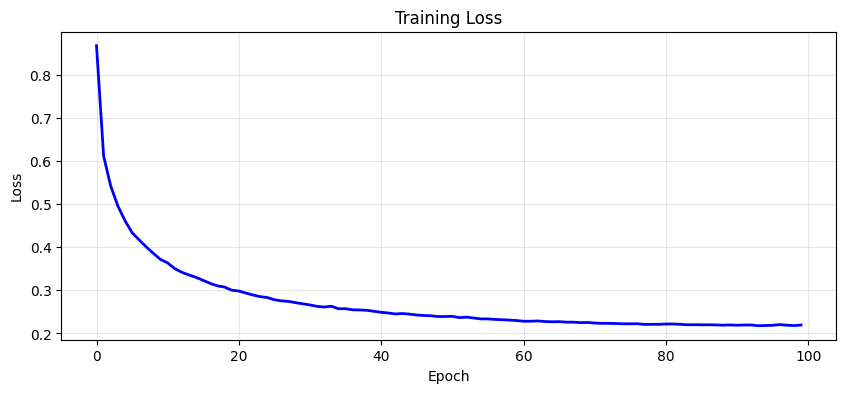


----------------------------------------
Step 2: Evaluation
----------------------------------------

  EVALUATION (Vectorized)

Extracting test features (stride=1)
Found 21 videos
Total clips: 11391


Extracting I3D:   0%|          | 0/2848 [00:00<?, ?it/s]

Feature stats: mean=1.4912, std=3.1877

Test clips: 11391
Computing reconstruction errors...


Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]

Aggregating frame scores...

Results:
  Frames: 11706
  Score range: [0.0000, 1.0000]
  Threshold: 0.4088
  Anomalies: 357 (3.0%)

Saved: avenue_scores.csv


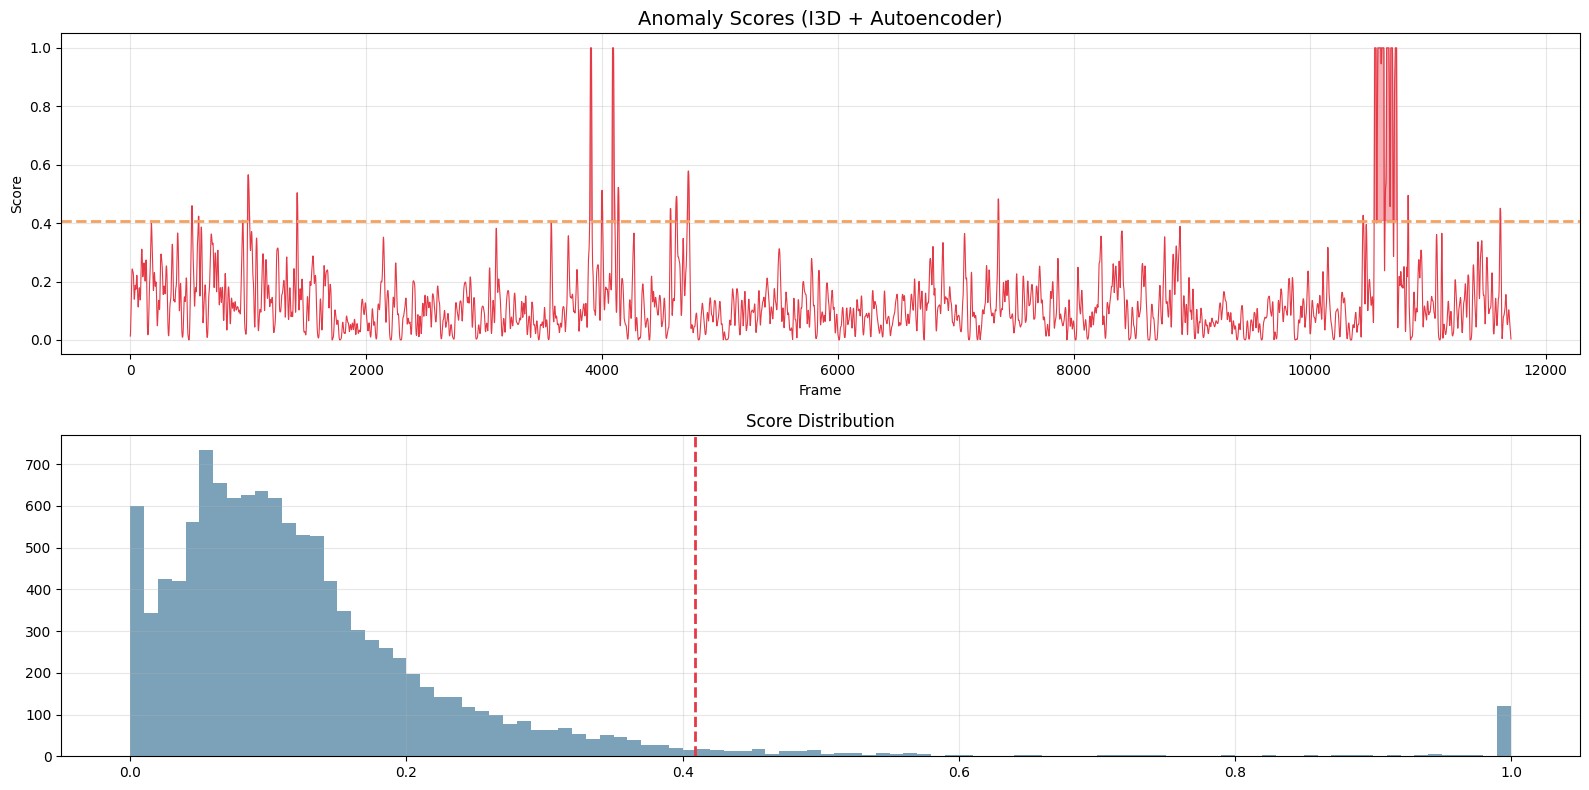


To generate additional visualizations, run:
  - generate_heatmaps_independent() for pixel-level heatmaps
  - generate_tsne_independent() for t-SNE visualization

  Done! Total time: 23.1 min

Optimizations applied:
  - Parallel image loading (ThreadPoolExecutor)
  - Batch normalization with broadcasting
  - Pre-allocated tensors for features
  - TensorDataset for efficient batching
  - Vectorized MSE computation
  - Vectorized score aggregation

Outputs generated:
  - training_loss.png: Training loss curve
  - anomaly_analysis.png: Anomaly scores and distribution
  - avenue_scores.csv: Frame-level anomaly scores

Independent Visualization Functions Available:

Run heatmap generation (separate cell):
  generate_heatmaps_independent()

Run t-SNE generation (separate cell):
  generate_tsne_independent()

These functions can be called independently after training.


In [16]:
# =============================================================================
# MAIN EXECUTION - TRAINING & EVALUATION
# =============================================================================

print("\n" + "=" * 60)
print("  AVENUE ANOMALY DETECTION - VECTORIZED")
print("  I3D + Simple Autoencoder + Proper Normalization")
print("=" * 60)

start = time.time()

# Check and install dependencies if needed
try:
    import pytorchvideo
    from sklearn.metrics import roc_auc_score
    print("\n[OK] Dependencies verified")
except ImportError:
    print("\n[INFO] Installing missing dependencies...")
    os.system("pip install pytorchvideo scikit-learn -q")

# Step 1: Train the autoencoder
print("\n" + "-" * 40)
print("Step 1: Training")
print("-" * 40)
model, train_stats = train()

# Step 2: Evaluate on test data
print("\n" + "-" * 40)
print("Step 2: Evaluation")
print("-" * 40)
scores, threshold = evaluate(model, train_stats)

# Summary
print(f"\n{'='*60}")
print(f"  Done! Total time: {(time.time() - start)/60:.1f} min")
print("=" * 60)

print("\nOptimizations applied:")
print("  - Parallel image loading (ThreadPoolExecutor)")
print("  - Batch normalization with broadcasting")
print("  - Pre-allocated tensors for features")
print("  - TensorDataset for efficient batching")
print("  - Vectorized MSE computation")
print("  - Vectorized score aggregation")

print("\nOutputs generated:")
print("  - training_loss.png: Training loss curve")
print("  - anomaly_analysis.png: Anomaly scores and distribution")
print("  - avenue_scores.csv: Frame-level anomaly scores")

print("\n" + "="*60)
print("Independent Visualization Functions Available:")
print("="*60)
print("\nRun heatmap generation (separate cell):")
print("  generate_heatmaps_independent()")
print("\nRun t-SNE generation (separate cell):")
print("  generate_tsne_independent()")
print("\nThese functions can be called independently after training.")


---

## Summary

This notebook implements a complete video anomaly detection pipeline:

### Architecture
- **Feature Extractor**: I3D (Inflated 3D ConvNet) pretrained on Kinetics
- **Anomaly Detector**: Simple autoencoder trained on normal features
- **Scoring**: MSE-based reconstruction error with temporal smoothing

### Visualizations
1. **Training Loss Curve**: Monitor convergence
2. **Anomaly Score Plot**: Frame-level scores with threshold
3. **Score Distribution**: Histogram of anomaly scores
4. **Pixel-Level Heatmaps**: Grad-CAM visualization showing spatial anomalies
5. **t-SNE Embedding**: 2D visualization of feature space

### Configuration Options
- Toggle heatmaps: `ENABLE_HEATMAPS = True/False`
- Toggle t-SNE: `ENABLE_TSNE = True/False`
- Adjust training: `NUM_EPOCHS`, `LEARNING_RATE`, `TRAIN_BATCH`

### References
- I3D Paper: "Quo Vadis, Action Recognition?" (Carreira & Zisserman, 2017)
- Avenue Dataset: "Abnormal Event Detection at 150 FPS in MATLAB" (Lu et al., 2013)


## 12. Run Heatmap Generation (Optional - Independent)

Execute this cell to generate pixel-level anomaly heatmaps.
Requires training to be completed first (model.pth must exist).



In [17]:
# =============================================================================
# EXECUTE HEATMAP GENERATION (INDEPENDENT)
# =============================================================================

print("\nStarting heatmap generation...")
generate_heatmaps_independent()



Starting heatmap generation...

  HEATMAP GENERATION (Independent - ALL VIDEOS)
Loading model from /kaggle/working/cache/features/best_model.pth...
Loading training stats from /kaggle/working/cache/features/train_stats.pth...

Generating Pixel-Level Heatmaps (ALL VIDEOS)
Found 21 videos

[1/21] Processing: 01
  Frames: 499


  Computing heatmaps:   0%|          | 0/8 [00:00<?, ?it/s]

  Saved: pixel_heatmaps_video01.png
  Saved: pixel_heatmaps_video01_overlay.png

[2/21] Processing: 02
  Frames: 1211


  Computing heatmaps:   0%|          | 0/8 [00:00<?, ?it/s]

  Saved: pixel_heatmaps_video02.png
  Saved: pixel_heatmaps_video02_overlay.png

[3/21] Processing: 03
  Frames: 737


  Computing heatmaps:   0%|          | 0/8 [00:00<?, ?it/s]

  Saved: pixel_heatmaps_video03.png
  Saved: pixel_heatmaps_video03_overlay.png

[4/21] Processing: 04
  Frames: 947


  Computing heatmaps:   0%|          | 0/8 [00:00<?, ?it/s]

  Saved: pixel_heatmaps_video04.png
  Saved: pixel_heatmaps_video04_overlay.png

[5/21] Processing: 05
  Frames: 1007


  Computing heatmaps:   0%|          | 0/8 [00:00<?, ?it/s]

  Saved: pixel_heatmaps_video05.png
  Saved: pixel_heatmaps_video05_overlay.png

[6/21] Processing: 06
  Frames: 627


  Computing heatmaps:   0%|          | 0/8 [00:00<?, ?it/s]

  Saved: pixel_heatmaps_video06.png
  Saved: pixel_heatmaps_video06_overlay.png

[7/21] Processing: 07
  Frames: 588


  Computing heatmaps:   0%|          | 0/8 [00:00<?, ?it/s]

  Saved: pixel_heatmaps_video07.png
  Saved: pixel_heatmaps_video07_overlay.png

[8/21] Processing: 08
  Frames: 36


  Computing heatmaps:   0%|          | 0/8 [00:00<?, ?it/s]

  Saved: pixel_heatmaps_video08.png
  Saved: pixel_heatmaps_video08_overlay.png

[9/21] Processing: 09
  Frames: 359


  Computing heatmaps:   0%|          | 0/8 [00:00<?, ?it/s]

  Saved: pixel_heatmaps_video09.png
  Saved: pixel_heatmaps_video09_overlay.png

[10/21] Processing: 10
  Frames: 722


  Computing heatmaps:   0%|          | 0/8 [00:00<?, ?it/s]

  Saved: pixel_heatmaps_video10.png
  Saved: pixel_heatmaps_video10_overlay.png

[11/21] Processing: 11
  Frames: 472


  Computing heatmaps:   0%|          | 0/8 [00:00<?, ?it/s]

  Saved: pixel_heatmaps_video11.png
  Saved: pixel_heatmaps_video11_overlay.png

[12/21] Processing: 12
  Frames: 735


  Computing heatmaps:   0%|          | 0/8 [00:00<?, ?it/s]

  Saved: pixel_heatmaps_video12.png
  Saved: pixel_heatmaps_video12_overlay.png

[13/21] Processing: 13
  Frames: 528


  Computing heatmaps:   0%|          | 0/8 [00:00<?, ?it/s]

  Saved: pixel_heatmaps_video13.png
  Saved: pixel_heatmaps_video13_overlay.png

[14/21] Processing: 14
  Frames: 496


  Computing heatmaps:   0%|          | 0/8 [00:00<?, ?it/s]

  Saved: pixel_heatmaps_video14.png
  Saved: pixel_heatmaps_video14_overlay.png

[15/21] Processing: 15
  Frames: 732


  Computing heatmaps:   0%|          | 0/8 [00:00<?, ?it/s]

  Saved: pixel_heatmaps_video15.png
  Saved: pixel_heatmaps_video15_overlay.png

[16/21] Processing: 16
  Frames: 740


  Computing heatmaps:   0%|          | 0/8 [00:00<?, ?it/s]

  Saved: pixel_heatmaps_video16.png
  Saved: pixel_heatmaps_video16_overlay.png

[17/21] Processing: 17
  Frames: 417


  Computing heatmaps:   0%|          | 0/8 [00:00<?, ?it/s]

  Saved: pixel_heatmaps_video17.png
  Saved: pixel_heatmaps_video17_overlay.png

[18/21] Processing: 18
  Frames: 275


  Computing heatmaps:   0%|          | 0/8 [00:00<?, ?it/s]

  Saved: pixel_heatmaps_video18.png
  Saved: pixel_heatmaps_video18_overlay.png

[19/21] Processing: 19
  Frames: 229


  Computing heatmaps:   0%|          | 0/8 [00:00<?, ?it/s]

  Saved: pixel_heatmaps_video19.png
  Saved: pixel_heatmaps_video19_overlay.png

[20/21] Processing: 20
  Frames: 273


  Computing heatmaps:   0%|          | 0/8 [00:00<?, ?it/s]

  Saved: pixel_heatmaps_video20.png
  Saved: pixel_heatmaps_video20_overlay.png

[21/21] Processing: 21
  Frames: 76


  Computing heatmaps:   0%|          | 0/8 [00:00<?, ?it/s]

  Saved: pixel_heatmaps_video21.png
  Saved: pixel_heatmaps_video21_overlay.png

Heatmap generation complete!
Outputs: pixel_heatmaps_video*.png and pixel_heatmaps_video*_overlay.png


## 13. Run t-SNE Generation (Optional - Independent)

Execute this cell to generate t-SNE visualization.
Requires training to be completed first (model.pth must exist).




Starting t-SNE generation...

  t-SNE GENERATION (Independent)
Loading model from /kaggle/working/cache/features/best_model.pth...
Loading training stats from /kaggle/working/cache/features/train_stats.pth...

Extracting test features...
[CACHE HIT] Loading test features
Test clips: 11391
Computing reconstruction errors...


Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]

Aggregating frame scores...

Score Statistics:
  Frames: 11706
  Range: [0.0000, 1.0000]
  Threshold: 0.4088

Generating t-SNE visualization...

Generating t-SNE Visualization
Total samples: 11391
Subsampling to 2000 samples for t-SNE...
Normal: 1939, Anomalous: 61
Running t-SNE (perplexity=30)...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE complete!


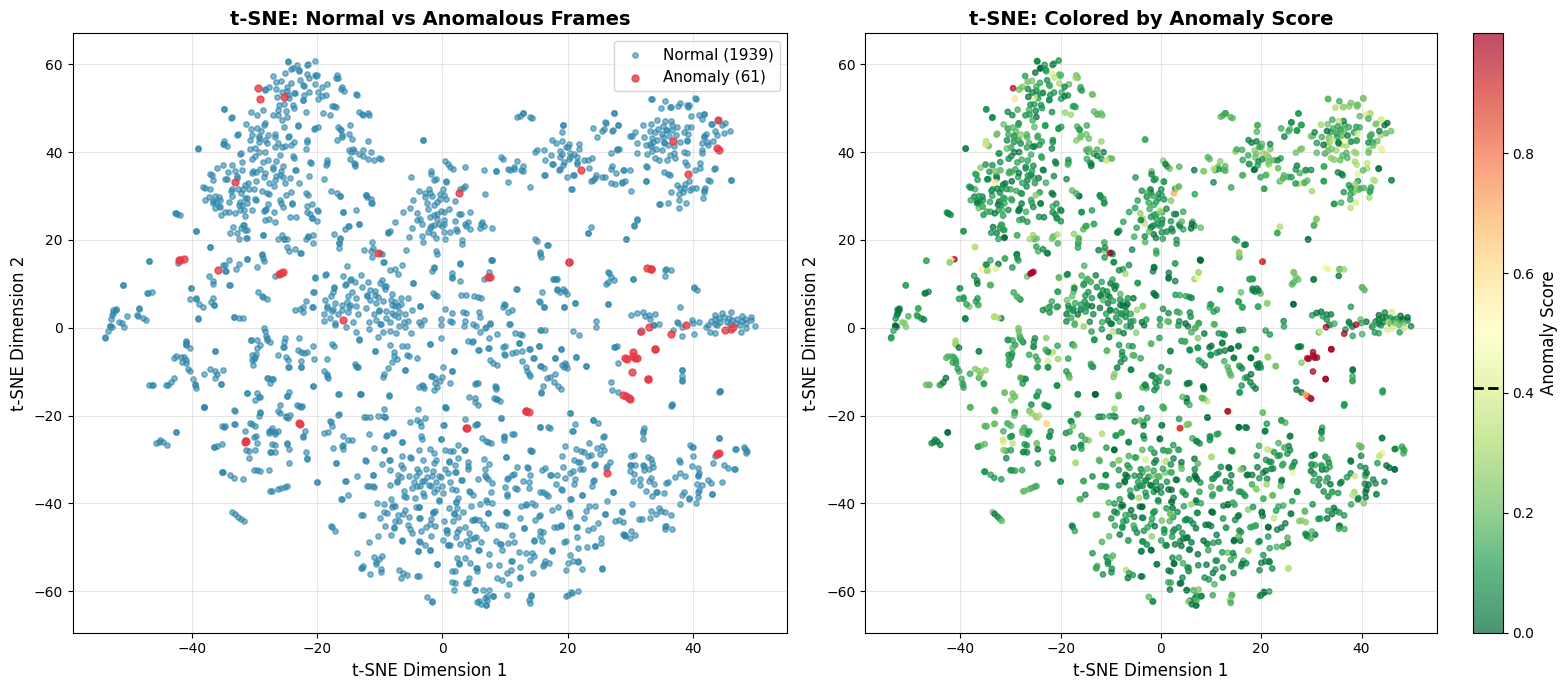

Saved: tsne_visualization.png

Embedding Statistics:
  Normal centroid:  (-0.31, -0.85)
  Anomaly centroid: (13.12, 3.90)
t-SNE generation complete!
Output: tsne_visualization.png


In [18]:
# =============================================================================
# EXECUTE t-SNE GENERATION (INDEPENDENT)
# =============================================================================

print("\nStarting t-SNE generation...")
generate_tsne_independent()


---

## 📋 Notebook Structure Summary

This notebook is now organized into **independent components** that can be run separately:

### Main Pipeline
1. **Section 11**: Training + Evaluation
   - Trains the autoencoder
   - Saves model to `best_model.pth`
   - Saves training stats to `train_stats.pth`
   - Generates anomaly scores and basic plot
   - **Run this first**

### Optional Independent Visualizations
2. **Section 12**: Heatmap Generation
   - Loads pre-trained model
   - Generates pixel-level Grad-CAM heatmaps
   - **Can be run anytime after Section 11**

3. **Section 13**: t-SNE Visualization
   - Loads pre-trained model
   - Extracts test features
   - Generates 2D t-SNE embeddings
   - **Can be run anytime after Section 11**

### Key Features of Independent Cells

✅ **Each visualization cell is self-contained**
- Loads necessary artifacts from disk
- Checks for required files before execution
- Provides clear error messages if dependencies missing

✅ **Can be run in any order** (after initial training)
- Run heatmaps, then t-SNE, then heatmaps again
- No need to re-train or re-extract features
- Saves computation time during development

✅ **Saved Artifacts**
- `best_model.pth`: Trained autoencoder weights
- `train_stats.pth`: Training normalization statistics
- `avenue_scores.csv`: Frame-level anomaly scores
- `training_loss.png`: Training curve
- `anomaly_analysis.png`: Score distribution
- `pixel_heatmaps.png`: Grad-CAM heatmaps
- `pixel_heatmaps_overlay.png`: Overlay version
- `tsne_visualization.png`: t-SNE embedding

### Usage Workflow

```python
# 1. First time: Run Section 11 (Training + Evaluation)
# This trains and evaluates, saves all artifacts

# 2. Generate visualizations independently:
generate_heatmaps_independent()    # Anytime after training
generate_tsne_independent()         # Anytime after training

# 3. Can re-run visualizations without retraining:
generate_heatmaps_independent()    # Runs in seconds
generate_tsne_independent()         # Runs in minutes

# 4. Modify settings and re-run:
HEATMAP_VIDEO_IDX = 2             # Change which video to visualize
HEATMAP_FRAMES = 16                # Change number of frames
generate_heatmaps_independent()    # New heatmaps, no retraining
```

